## 1. Project Overview

Build a multi-class classifier (COVID-19, Viral Pneumonia, Normal) from chest X-ray images using transfer learning (VGG16 / ResNet50 / DenseNet) with Grad-CAM visual explanations and a simple Streamlit web UI, packaged with Docker.

### Goals:
+ Robust preprocessing & augmentation.
+ Transfer learning with fine-tuning
+ Class imbalance handling
+ Metrics: accuracy, precision, recall, F1, ROC-AUC
+ Confusion matrix + Grad-CAM overlays

In [ ]:
# Imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import cv2
from pathlib import Path

In [ ]:
# Configuration
DATA_DIR = "C:/Users/Mayank Meghwal/Desktop/DS GUVI/Projects/Final Project/Covid19_Detection/Covid19-dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
VAL_SPLIT = 0.20
RND = 42

In [3]:
# --- Reproducibility ---
os.environ['PYTHONHASHSEED'] = str(RND)
random.seed(RND)
np.random.seed(RND)
tf.random.set_seed(RND)



In [ ]:
# Path Setup
train_dir = os.path.join(DATA_DIR, "train")
test_dir = os.path.join(DATA_DIR, "test")
assert os.path.isdir(train_dir), f"Training directory not found: {train_dir}"
assert os.path.isdir(test_dir), f"Test directory not found: {test_dir}"
print("Setup complete.")

Setup complete.


## Data Augmentation & Generators for ResNet50

In [ ]:
# Data Augmentation & Generators for ResNet50
# More aggressive augmentation to improve robustness and reduce overfitting
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VAL_SPLIT
)

test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=RND,
    color_mode='rgb'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=RND,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=RND,
    color_mode='rgb'
)

NUM_CLASSES = train_generator.num_classes
CLASS_LABELS = list(train_generator.class_indices.keys())
print(f"Found {NUM_CLASSES} classes: {CLASS_LABELS}")

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Found 3 classes: ['Covid', 'Normal', 'Viral Pneumonia']


In [ ]:
# Calculate Class Weights to Handle Imbalance
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights_array))
print(f"Computed Class Weights to balance dataset: {class_weights}")

Computed Class Weights to balance dataset: {0: 0.7528089887640449, 1: 1.1964285714285714, 2: 1.1964285714285714}


In [ ]:
# Model Building Function with Increased Regularization
def build_and_finetune_model(input_shape, num_classes, dropout=0.6):
    """
    Builds a robust transfer learning model with a custom classification head.
    """
    tf.keras.backend.clear_session()

    # Load ResNet50
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)

    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model, base_model

## Build and Train the ResNet50 Model

In [ ]:
# Build and Train the ResNet50 Model
print("\nBuilding ResNet50 model...")
model, base_model = build_and_finetune_model(input_shape=(*IMG_SIZE, 3), num_classes=NUM_CLASSES)


Building ResNet50 model...



In [ ]:
# PHASE 1
print("\n--- PHASE 1: Training the classification head ---")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks for Phase 1
callbacks_phase1 = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks_phase1,
    class_weight=class_weights
)


--- PHASE 1: Training the classification head ---


c:\Users\Mayank Meghwal\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.6915 - loss: 0.7727 - val_accuracy: 0.7800 - val_loss: 0.6270 - learning_rate: 0.0010
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9104 - loss: 0.2812 - val_accuracy: 0.7400 - val_loss: 0.6589 - learning_rate: 0.0010
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8955 - loss: 0.3238 - val_accuracy: 0.8000 - val_loss: 0.6736 - learning_rate: 0.0010
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8806 - loss: 0.4183 - val_accuracy: 0.8600 - val_loss: 0.5897 - learning_rate: 2.0000e-04
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9104 - loss: 0.2164 - val_accuracy: 0.8200 - val_loss: 0.6407 - learning_rate: 2.0000e-04
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9104 - loss: 0.2907 - val_accuracy: 0.8400 - val_loss: 0.6153 - learning_rate: 2.0000e-04
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9055 - loss: 0.2409 - va

## Fine-Tuning

In [ ]:
# Phase 2
print("\n--- PHASE 2: Fine-tuning the top layers of ResNet50 ---")
base_model.trainable = True

for layer in base_model.layers[:143]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


--- PHASE 2: Fine-tuning the top layers of ResNet50 ---


In [ ]:
# Callbacks for Phase 2 and saving the best model
callbacks_phase2 = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7),
    ModelCheckpoint("resnet50_finetuned_best.keras", save_best_only=True, monitor="val_accuracy")
]

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks_phase2,
    class_weight=class_weights
)

# Load the best performing model
model = keras.models.load_model("Model.keras")
print("Best fine-tuned model loaded successfully.")

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.8557 - loss: 0.4079 - val_accuracy: 0.9000 - val_loss: 0.3574 - learning_rate: 1.0000e-05
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8905 - loss: 0.2853 - val_accuracy: 0.9000 - val_loss: 0.3001 - learning_rate: 1.0000e-05
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9005 - loss: 0.2859 - val_accuracy: 0.8800 - val_loss: 0.4563 - learning_rate: 1.0000e-05
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.9005 - loss: 0.2291 - val_accuracy: 0.8600 - val_loss: 0.6162 - learning_rate: 1.0000e-05
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9005 - loss: 0.2614 - val_accuracy: 0.8800 - val_loss: 0.4842 - learning_rate: 1.0000e-05
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9254 - loss: 0.2232 - val_accuracy: 0.8600 - val_loss: 0.4400 - learning_rate: 2.0000e-06
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8955 - loss:

## Final Evaluation

In [ ]:

# Final Evaluation
print("\n--- Evaluating final model on the test set ---")
results = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")


--- Evaluating final model on the test set ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 984ms/step - accuracy: 0.8636 - loss: 0.4118
Test Loss: 0.4118
Test Accuracy: 0.8636


In [14]:
# Detailed report
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_LABELS, digits=4))


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step

Classification Report:
                 precision    recall  f1-score   support

          Covid     1.0000    0.8077    0.8936        26
         Normal     0.7037    0.9500    0.8085        20
Viral Pneumonia     0.9444    0.8500    0.8947        20

       accuracy                         0.8636        66
      macro avg     0.8827    0.8692    0.8656        66
   weighted avg     0.8934    0.8636    0.8682        66



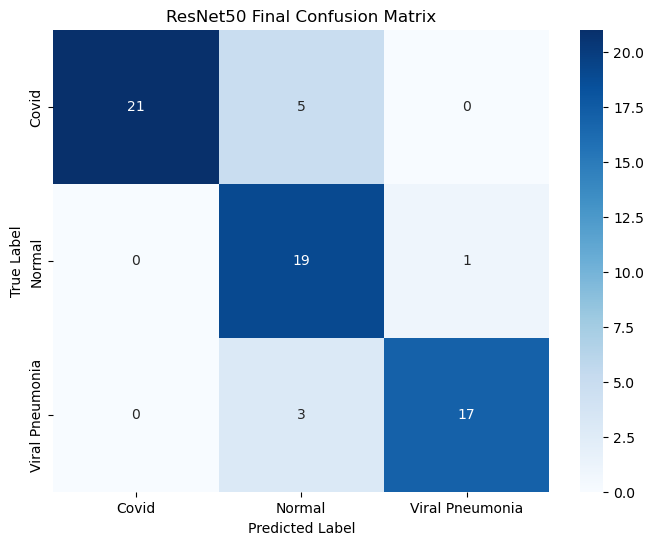

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("ResNet50 Final Confusion Matrix")
plt.show()


Model 'resnet50_finetuned_best.keras' loaded successfully.
--------------------------------------------------
Testing a 'COVID' image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
File: 094.png
Predicted Class: **COVID**
Confidence: **81.94%**



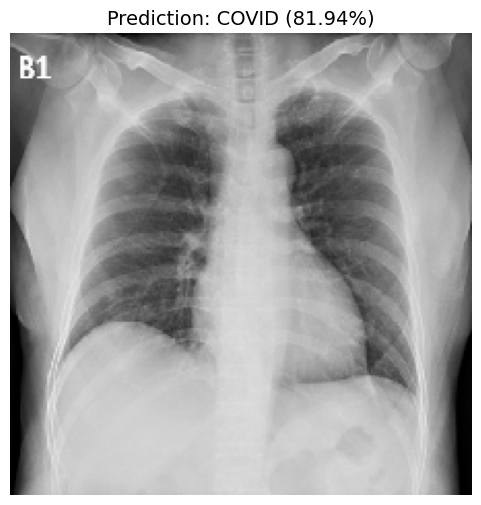

--------------------------------------------------
Testing a 'Normal' image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
File: 0101.jpeg
Predicted Class: **Normal**
Confidence: **94.85%**



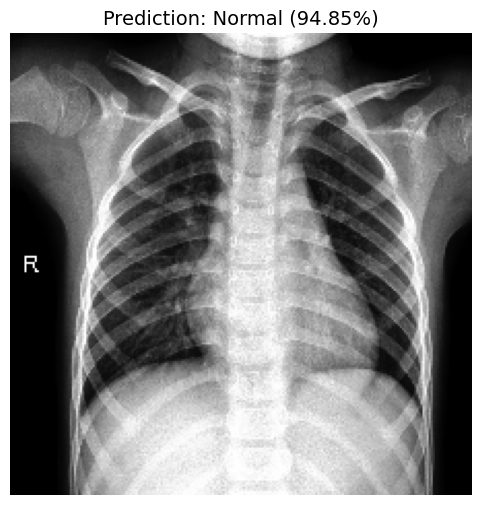

--------------------------------------------------
Testing a 'Viral Pneumonia' image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
File: 0101.jpeg
Predicted Class: **Viral Pneumonia**
Confidence: **77.17%**



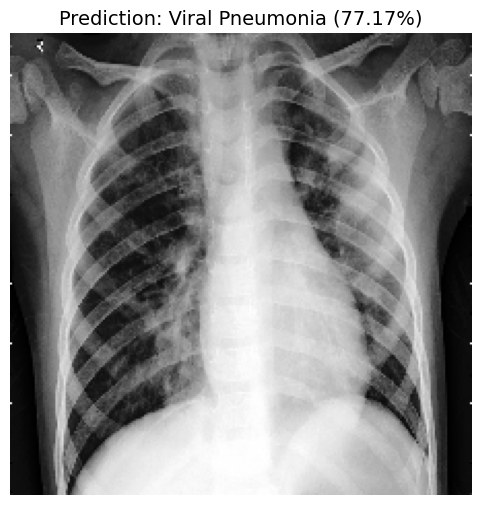

In [ ]:
# Load your trained model
model_path = 'resnet50_finetuned_best.keras'
try:
    model = keras.models.load_model(model_path)
    print(f"Model '{model_path}' loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
# Define a function for prediction and display
def predict_and_show(image_path, model_to_test, labels):
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}\nSkipping this image.")
        return

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    processed_img = resnet_preprocess(img_array_expanded)

    # Make the prediction
    predictions = model_to_test.predict(processed_img)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_label = labels[predicted_class_index]
    confidence = np.max(predictions[0]) * 100

    # Display the result
    print(f"File: {os.path.basename(image_path)}")
    print(f"Predicted Class: **{predicted_class_label}**")
    print(f"Confidence: **{confidence:.2f}%**\n")

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class_label} ({confidence:.2f}%)", fontsize=14)
    plt.axis('off')
    plt.show()

# Define paths
base_test_dir = r'C:\Users\Mayank Meghwal\Desktop\DS GUVI\Projects\Final Project\Covid19_Detection\Covid19-dataset\test'
class_labels = ['COVID', 'Normal', 'Viral Pneumonia']
images_to_test = {
    "COVID": os.path.join(base_test_dir, 'COVID', '094.png'),
    "Normal": os.path.join(base_test_dir, 'Normal', '0101.jpeg'),
    "Viral Pneumonia": os.path.join(base_test_dir, 'Viral Pneumonia', '0101.jpeg')
}

# Test each image
if 'model' in locals():
    for true_label, path in images_to_test.items():
        print("-" * 50)
        print(f"Testing a '{true_label}' image...")
        predict_and_show(path, model, class_labels)

In [ ]:
# Model size decrement
model_path = 'Model.keras'
print(f"Loading model from: {model_path}")
model = keras.models.load_model(model_path)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

print("Quantizing model... This may take a moment.")
tflite_quant_model = converter.convert()
print("Quantization complete.")

quantized_model_path = 'model_quantized.tflite'
with open(quantized_model_path, 'wb') as f:
    f.write(tflite_quant_model)
    
original_size = os.path.getsize(model_path) / (1024 * 1024)
quantized_size = os.path.getsize(quantized_model_path) / (1024 * 1024)

print(f"\nOriginal model size: {original_size:.2f} MB")
print(f"Quantized model size: {quantized_size:.2f} MB")
print(f"New model saved as '{quantized_model_path}'")